In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import CoraFull, BitcoinOTC
import matplotlib.pyplot as plt
from torch_geometric.nn import SAGEConv
import pandas as pd
import os
import numpy as np
from datetime import datetime

/home/rustambaku13/miniconda3/envs/flink/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Create Dataset

In [18]:
dataset = CoraFull("./datasets")

Data(x=[19793, 8710], edge_index=[2, 126842], y=[19793])

### Trash

In [ ]:
sorted_ratings = pd.read_csv("../datasets/movielens/sorted_ratings.csv", header=None)

In [85]:
num_nodes = np.unique(np.hstack((sorted_ratings[0].unique(), sorted_ratings[1].unique()))).size
x = np.random.normal(size=(num_nodes, 7))
edge_index = torch.tensor(np.vstack((sorted_ratings[0].values, sorted_ratings[1].values)))

data = Data(x=x, edge_index=edge_index)


In [108]:
data.num_node_features = 7

### Model Definitions

In [23]:
class GraphSage(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        self.conv1 = SAGEConv(dataset.num_node_features, 128)
        self.conv2 = SAGEConv(128, 64)
        self.ff = torch.nn.Sequential(
            torch.nn.Linear(64,64),
            torch.nn.Linear(64, dataset.num_classes)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        if self.training:
            x = F.dropout(x, 0.2)
        x = self.ff(x)
        return F.softmax(x)
model = GraphSage()


### Training Loop for 2 layered GCN Normal

In [29]:
losses = list()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(dataset[0])
    loss = F.cross_entropy(out, dataset[0].y)
    print(loss)
    loss.backward()
    
    optimizer.step()

<ipython-input-23-aa6beccaf25d>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


tensor(4.2259, grad_fn=<NllLossBackward0>)
tensor(4.2259, grad_fn=<NllLossBackward0>)
tensor(4.2259, grad_fn=<NllLossBackward0>)
tensor(4.2259, grad_fn=<NllLossBackward0>)
tensor(4.2259, grad_fn=<NllLossBackward0>)
tensor(4.2259, grad_fn=<NllLossBackward0>)
tensor(4.2259, grad_fn=<NllLossBackward0>)
tensor(4.2259, grad_fn=<NllLossBackward0>)
tensor(4.2259, grad_fn=<NllLossBackward0>)
tensor(4.2258, grad_fn=<NllLossBackward0>)
tensor(4.2256, grad_fn=<NllLossBackward0>)
tensor(4.2228, grad_fn=<NllLossBackward0>)
tensor(4.2139, grad_fn=<NllLossBackward0>)
tensor(4.2277, grad_fn=<NllLossBackward0>)
tensor(4.2206, grad_fn=<NllLossBackward0>)
tensor(4.2220, grad_fn=<NllLossBackward0>)
tensor(4.2246, grad_fn=<NllLossBackward0>)
tensor(4.2247, grad_fn=<NllLossBackward0>)
tensor(4.2233, grad_fn=<NllLossBackward0>)
tensor(4.2187, grad_fn=<NllLossBackward0>)
tensor(4.2174, grad_fn=<NllLossBackward0>)
tensor(4.2141, grad_fn=<NllLossBackward0>)
tensor(4.2070, grad_fn=<NllLossBackward0>)
tensor(4.20

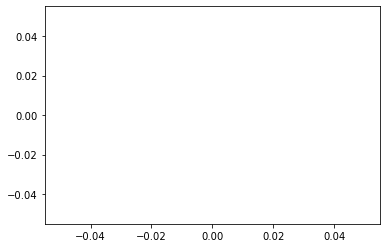

In [30]:
plt.plot(range(0, len(losses) ),losses)

### Saving model weights for Java

In [31]:
def save_model(model_name):
    directory = os.path.join(os.path.curdir, "models/%s-%s/"%(model_name, datetime.now().date()))
    if not os.path.exists(directory):
        os.makedirs(directory)
    i = 0
    for name, param in model.named_parameters():
        np.save(os.path.join(directory, str(i)), param.data.numpy())
        i+=1

In [32]:
save_model("GraphSageBias")

In [69]:
save_model("GraphSage-CoraFull")

In [35]:
for name, param in model.named_parameters():
        print(name, param.data
             )

conv1.lin_l.weight tensor([[ 5.9817e-04, -7.0787e-05, -5.4747e-04,  ..., -3.3149e-04,
         -4.4059e-05,  5.0848e-04],
        [ 3.6469e-04, -3.0985e-05, -2.0252e-04,  ...,  1.8046e-04,
          5.9921e-05, -1.7280e-04],
        [ 1.7388e-05, -3.6469e-05, -1.6838e-05,  ..., -8.8189e-07,
          5.4335e-05, -1.1658e-05],
        ...,
        [ 3.5179e-02, -3.3621e-03,  7.1993e-03,  ...,  3.2074e-03,
         -1.1755e-02, -2.1390e-02],
        [ 1.4919e-03,  8.9092e-05,  1.3309e-04,  ...,  8.8052e-04,
         -9.8132e-05,  9.5137e-05],
        [ 1.5220e-05, -4.7328e-06,  2.9160e-06,  ..., -3.2813e-06,
         -4.0589e-06,  7.9701e-06]])
conv1.lin_l.bias tensor([-3.4710e-02, -3.0312e-02, -1.3198e-02, -2.6130e-02,  2.2755e-03,
        -2.3397e-04, -1.9671e-03, -1.0809e-02, -3.9789e-02, -4.3510e-03,
         1.0627e-02, -1.2442e-04, -3.9706e-02, -1.0531e-02,  4.2310e-02,
        -1.5630e-03, -5.3830e-02, -3.5905e-02, -7.4253e-04,  4.9156e-02,
         5.2823e-02, -1.5396e-02, -6.539

### Saving Graph for Java

In [3]:
edges = pd.DataFrame(dataset.data.edge_index.numpy().T)
edges.to_csv("datasets/cora/edges", index = False, header=False)

In [4]:
vertices = pd.DataFrame({
"id": list(range(0, dataset.data.x.size()[0])),
"feature": dataset.data.x.numpy().tolist(),
"label" : dataset.data.y.numpy()
}).to_csv("datasets/cora/vertices", index = False, header = False)

In [5]:
labels = pd.DataFrame({
     "id": list(range(0, dataset.data.y.size()[0])),
    "label": dataset.data.y.numpy() 
})
labels.to_csv("datasets/cora/labels", index = False, header = False)